<h1 style="color: 	#80B1D3;"><strong>Vanguard A/B test</strong></h1>

<h2 style="color: 	#B3DE69;"><strong>Librerias</strong></h2>

In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import chi2_contingency, norm
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import ttest_ind
from scipy.stats import chi2_contingency

%matplotlib inline

In [169]:
df_final_demo = pd.read_csv("../data/raw/df_final_demo.txt")
df_exp_cli = pd.read_csv("../data/raw/df_final_experiment_clients.txt")
df_web_1 = pd.read_csv("../data/raw/df_final_web_data_pt_1.txt")
df_web_2 = pd.read_csv("../data/raw/df_final_web_data_pt_2.txt")

<h2 style="color: 	#B3DE69;"><strong>Exploración</strong></h2>

In [170]:
df_final_demo.head()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,836976,6.0,73.0,60.5,U,2.0,45105.30,6.0,9.0
1,2304905,7.0,94.0,58.0,U,2.0,110860.30,6.0,9.0
2,1439522,5.0,64.0,32.0,U,2.0,52467.79,6.0,9.0
3,1562045,16.0,198.0,49.0,M,2.0,67454.65,3.0,6.0
4,5126305,12.0,145.0,33.0,F,2.0,103671.75,0.0,3.0


In [171]:
df_final_demo.shape

(70609, 9)

In [172]:
df_exp_cli.head()

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control


In [173]:
df_exp_cli.isna().sum()

client_id        0
Variation    20109
dtype: int64

In [174]:
df_exp_cli.shape

(70609, 2)

In [175]:
df_web_1.head()

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


In [176]:
df_web_2.head()

,client_id,visitor_id,visit_id,process_step,date_time
0,763412,601952081_10457207388,397475557_40440946728_419634,confirm,2017-06-06 08:56:00
1,6019349,442094451_91531546617,154620534_35331068705_522317,confirm,2017-06-01 11:59:27
2,6019349,442094451_91531546617,154620534_35331068705_522317,step_3,2017-06-01 11:58:48
3,6019349,442094451_91531546617,154620534_35331068705_522317,step_2,2017-06-01 11:58:08
4,6019349,442094451_91531546617,154620534_35331068705_522317,step_1,2017-06-01 11:57:58


<h2 style="color: 	#B3DE69;"><strong>Juntar DFs</strong></h2>

In [177]:
df_web = pd.concat([df_web_1, df_web_2], axis=0)
df_web.head()

,client_id,visitor_id,visit_id,process_step,date_time
0,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:27:07
1,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:26:51
2,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:19:22
3,9988021,580560515_7732621733,781255054_21935453173_531117,step_2,2017-04-17 15:19:13
4,9988021,580560515_7732621733,781255054_21935453173_531117,step_3,2017-04-17 15:18:04


In [178]:
df_web['date_time'] = pd.to_datetime(df_web['date_time'], errors='coerce')

In [179]:
df = pd.merge(df_final_demo, df_exp_cli, on ='client_id',how='outer')
df.head()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,Variation
0,169,21.0,262.0,47.5,M,2.0,501570.72,4.0,4.0,NaN
1,555,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,Test
2,647,12.0,151.0,57.5,M,2.0,30525.80,0.0,4.0,Test
3,722,11.0,143.0,59.5,F,2.0,22466.17,1.0,1.0,NaN
4,934,9.0,109.0,51.0,F,2.0,32522.88,0.0,3.0,Test


<h2 style="color: 	#B3DE69;"><strong>Limpieza del primer DF</strong></h2>

In [180]:
df.head()

,client_id,clnt_tenure_yr,clnt_tenure_mnth,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,Variation
0,169,21.0,262.0,47.5,M,2.0,501570.72,4.0,4.0,NaN
1,555,3.0,46.0,29.5,U,2.0,25454.66,2.0,6.0,Test
2,647,12.0,151.0,57.5,M,2.0,30525.80,0.0,4.0,Test
3,722,11.0,143.0,59.5,F,2.0,22466.17,1.0,1.0,NaN
4,934,9.0,109.0,51.0,F,2.0,32522.88,0.0,3.0,Test


In [181]:
df.shape

(70609, 10)

In [182]:
df.dtypes

client_id             int64
clnt_tenure_yr      float64
clnt_tenure_mnth    float64
clnt_age            float64
gendr                object
num_accts           float64
bal                 float64
calls_6_mnth        float64
logons_6_mnth       float64
Variation            object
dtype: object

In [183]:
df['clnt_tenure_yr'].unique()

array([21.,  3., 12., 11.,  9.,  5.,  8.,  7., 48., 14., 19., 23., 13.,
        4., 15.,  6., 16., 30., 27., 18., 20., 22., 17., 10., 24., 26.,
       25., 28., 29., 43., 32., 31., 34., 36., 55., 33., 35.,  2., 51.,
       37., 38., nan, 62., 40., 45., 39., 50., 52., 47., 44., 42., 41.,
       46., 54., 49.])

In [184]:
np.sort(df['clnt_tenure_yr'].unique())

array([ 2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
       15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27.,
       28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.,
       41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 54.,
       55., 62., nan])

In [185]:
df['clnt_tenure_yr'] = df['clnt_tenure_yr'].astype('Int64')

In [186]:
df['clnt_tenure_mnth'].unique()

array([262.,  46., 151., 143., 109., 145.,  66.,  99.,  85., 576., 177.,
        60., 150., 139., 229., 280., 260., 110., 157.,  98.,  63., 179.,
       231., 142.,  58., 117., 116., 189., 190.,  75.,  94., 172., 199.,
       154.,  86.,  77., 253., 361.,  57., 173.,  92., 329.,  72.,  81.,
       149., 155.,  89., 195., 141., 106., 252., 218., 364., 140., 241.,
       257., 226., 269., 170., 164.,  78., 108.,  56., 105.,  88., 211.,
       205.,  73., 194.,  69., 171., 126.,  71.,  83., 121., 299., 156.,
       285., 191., 321., 200.,  55.,  76., 242., 281., 294., 224., 166.,
        70., 304.,  65., 169., 264., 230., 222., 160., 192.,  74.,  84.,
        82., 168., 124., 119., 342., 219., 163., 144., 193., 131., 118.,
       158.,  87., 186., 107., 196.,  91., 277., 125., 122., 259., 178.,
       123., 310., 181., 232., 352., 214., 114., 250., 101.,  59., 345.,
       282.,  80., 129.,  68., 184., 174., 268., 246., 176., 183.,  95.,
        48., 255., 215., 100., 298., 187., 355., 31

In [187]:
df['clnt_tenure_mnth'] = df['clnt_tenure_mnth'].astype('Int64')

In [188]:
df['clnt_age'].unique()

array([47.5, 29.5, 57.5, 59.5, 51. , 36. , 48. , 22. , 54.5, 28.5, 42. ,
       46. , 45. , 58.5, 51.5, 55. , 43. , 62.5, 46.5, 37.5, 26.5, 63.5,
       56. , 25. , 52. , 63. , 30. , 70.5, 48.5, 38.5, 58. , 40. , 65.5,
       64.5, 50.5, 40.5, 29. , 76. , 25.5, 67. , 35.5, 53. , 61.5, 41.5,
       33. , 44. , 50. , 30.5, 55.5, 34. , 27. , 22.5, 38. , 36.5, 82. ,
       26. , 74. , 23. , 31.5, 60. , 53.5, 28. , 37. , 39. , 27.5, 77.5,
       52.5, 19.5, 62. , 34.5, 69. , 54. , 45.5, 65. , 21. , 20. , 60.5,
       74.5, 68. , 61. , 41. , 43.5, 75.5, 49.5, 32. , 67.5, 19. , 49. ,
       23.5, 33.5, 24. , 76.5, 71. , 59. , 15.5, 69.5, 56.5, 66. , 32.5,
       42.5, 57. , 47. , 81.5, 31. , 44.5, 71.5, 70. , 24.5, 75. , 77. ,
       81. , 14.5, 86.5, 73. , 39.5, 73.5, 79.5, 21.5, 85. , 35. , 80. ,
       72.5, 78. , 18.5, 64. , 68.5, 66.5, 84. , 72. , 20.5, 83. , 91. ,
       83.5, 16.5, 18. , 95.5, 82.5, 16. , 17. , 17.5, 80.5, 84.5, 78.5,
       92. , 79. , 89. ,  nan, 15. , 90. , 86. , 87

In [189]:
df['num_accts'].unique()

array([ 2.,  3.,  5.,  4.,  6.,  8., nan,  7.,  1.])

In [190]:
df['num_accts'] = df['num_accts'].astype('Int64')

In [191]:
df['calls_6_mnth'].unique()

array([ 4.,  2.,  0.,  1.,  6.,  5.,  3.,  7., nan])

In [192]:
df['calls_6_mnth'] = df['calls_6_mnth'].astype('Int64')

In [193]:
df['logons_6_mnth'].unique()

array([ 4.,  6.,  1.,  3.,  9.,  5.,  8.,  7.,  2., nan])

In [194]:
df['logons_6_mnth'] = df['logons_6_mnth'].astype('Int64')

In [195]:
df.columns = df.columns.str.lower()

In [196]:
df['gendr'].unique()

array(['M', 'U', 'F', nan, 'X'], dtype=object)

In [197]:
df.duplicated().sum()

0

In [198]:
df['gendr'] = df['gendr'].fillna('U')

In [199]:
df['variation'] = df['variation'].fillna('no_experiment')

In [200]:
df.isnull().sum()

client_id            0
clnt_tenure_yr      14
clnt_tenure_mnth    14
clnt_age            15
gendr                0
num_accts           14
bal                 14
calls_6_mnth        14
logons_6_mnth       14
variation            0
dtype: int64

In [201]:
df['clnt_age'] = df['clnt_age'].fillna(df['clnt_age'].mean())

In [202]:
df.dropna(subset=['num_accts'], inplace=True)

<h2 style="color: 	#80B1D3;"><strong>Análisis</strong></h2>

<h2 style="color: 	#80B1D3;">¿Quienes son los principales clientes que utilizan este proceso en linea?</h2>

In [203]:
# Primero queremos saber que cantidad de gente ha tomado el test.
frequency_table = df['variation'].value_counts()
frequency_table = frequency_table.loc[['Test', 'Control']]

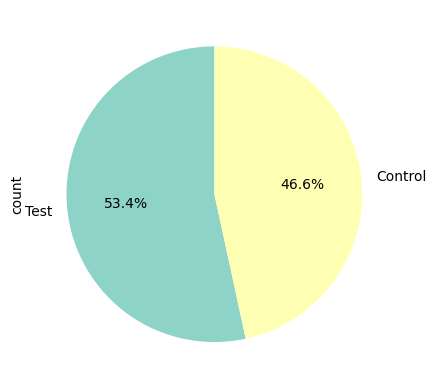

In [204]:
frequency_table.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette("Set3"))
plt.show()

C:\Users\rocio\AppData\Local\Temp\ipykernel_3704\1961423030.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=frequency_table.index, y=frequency_table.values, palette="Set3")


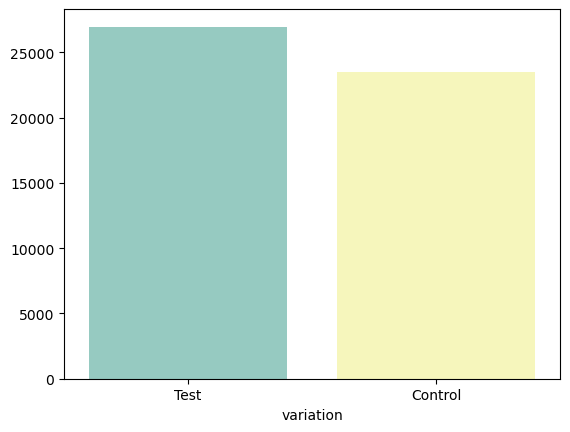

In [205]:
sns.barplot(x=frequency_table.index, y=frequency_table.values, palette="Set3")
plt.show()

<h3 style="color: 	#80B1D3;">¿Son más bien jóvenes o mayores?</h3>

In [206]:
df['clnt_age'].describe()

count    70595.000000
mean        46.442240
std         15.591162
min         13.500000
25%         32.500000
50%         47.000000
75%         59.000000
max         96.000000
Name: clnt_age, dtype: float64

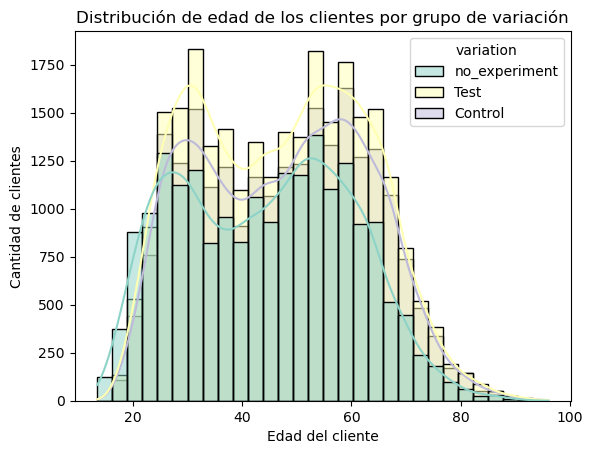

In [207]:
sns.histplot(data=df, x='clnt_age', hue='variation', kde=True, bins=30, palette="Set3")
plt.title('Distribución de edad de los clientes por grupo de variación')
plt.xlabel('Edad del cliente')
plt.ylabel('Cantidad de clientes')
plt.show()

Desde los 20 años en adelante, hay una base sólida de usuarios. Esto sugiere que la plataforma online está siendo usada activamente por **adultos jóvenes en adelante**.

Primer pico en los 30s (~35 años):
Probablemente representa a clientes que ya han comenzado a ahorrar/invertir activamente y están cómodos usando herramientas digitales.

Segundo pico en los 50s (~57 años):
Personas en etapa más avanzada de su carrera profesional. Probablemente con más patrimonio y uso activo de servicios financieros, pero también digitalmente competentes.

C:\Users\rocio\AppData\Local\Temp\ipykernel_3704\1942034299.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='variation', y='clnt_age',palette="Set3")


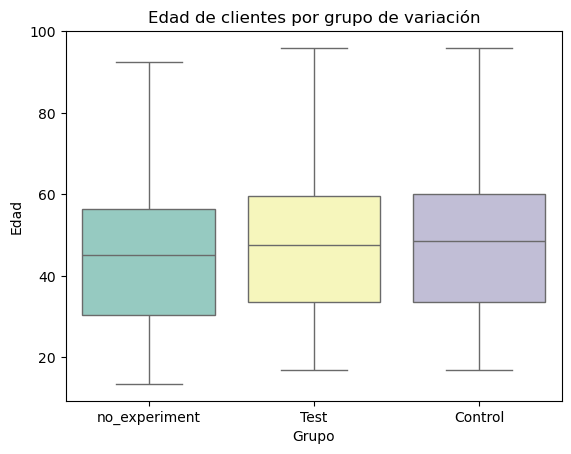

In [208]:
sns.boxplot(data=df, x='variation', y='clnt_age',palette="Set3")
plt.title('Edad de clientes por grupo de variación')
plt.xlabel('Grupo')
plt.ylabel('Edad')
plt.show()

Los de test y los de control tienen edades similares.

**Resumen**: 

La mayoría de los clientes que usan el proceso online tienen más de 20 años, con dos grupos destacados alrededor de los 35 y 57 años. Esto indica que tanto adultos jóvenes como clientes de mediana edad son los principales usuarios del proceso digital.

<h3 style="color: 	#B3DE69;">¿Clientes nuevos o con más antigüedad?</h3>

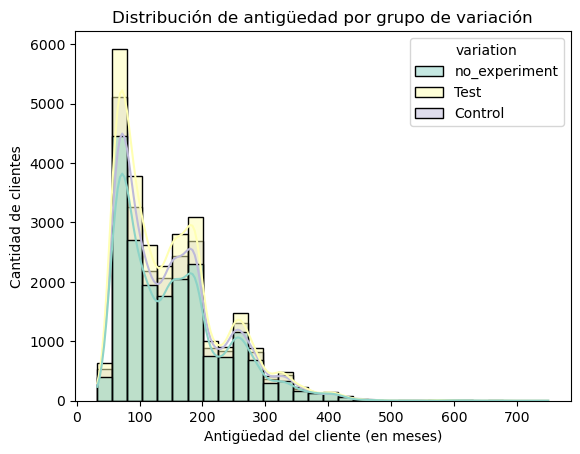

In [209]:
sns.histplot(data=df, x='clnt_tenure_mnth', hue='variation', kde=True, bins=30, palette='Set3')
plt.title('Distribución de antigüedad por grupo de variación')
plt.xlabel('Antigüedad del cliente (en meses)')
plt.ylabel('Cantidad de clientes')
plt.show()

C:\Users\rocio\AppData\Local\Temp\ipykernel_3704\1487374077.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='variation', y='clnt_tenure_mnth', palette='Set3')


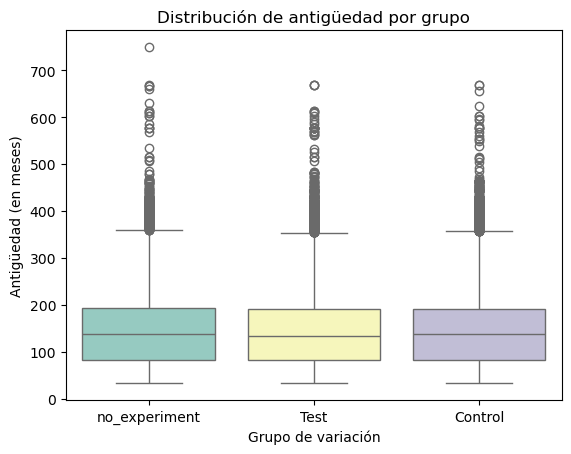

In [210]:
sns.boxplot(data=df, x='variation', y='clnt_tenure_mnth', palette='Set3')
plt.title('Distribución de antigüedad por grupo')
plt.xlabel('Grupo de variación')
plt.ylabel('Antigüedad (en meses)')
plt.show()

La antigüedad se mide en meses, y la mayoría de los clientes tienen entre **50 y 80 meses (aproximadamente 4 a 6.5 años)**, donde se observa el pico más alto con cerca de 6000 clientes.

Existe un segundo pico menos pronunciado entre 175 y 200 meses (14.5 a 16.5 años), ceerca de 3000 clientes.

El rango intercuartílico (IQR) de antigüedad — es decir, el 50% central de los clientes — se encuentra entre 100 y 200 meses (aproximadamente 8 a 16 años).

Esto indica que la mayoría de los clientes tienen una antigüedad media a alta, aunque también hay clientes con antiguedades mucho más altas que se consideran outliers en la distribución.

La presencia de estos dos picos y el rango concentrado sugiere que tanto clientes relativamente nuevos como clientes con una larga trayectoria están activos en el proceso online, con una mayor concentración en rangos medios y altos de antigüedad, teniendo en cuenta que interpretamos que 4 años es medio alto.

<h3 style="color: 	#80B1D3;">¿Tienen sueldos más altos o más bajos?</h3>

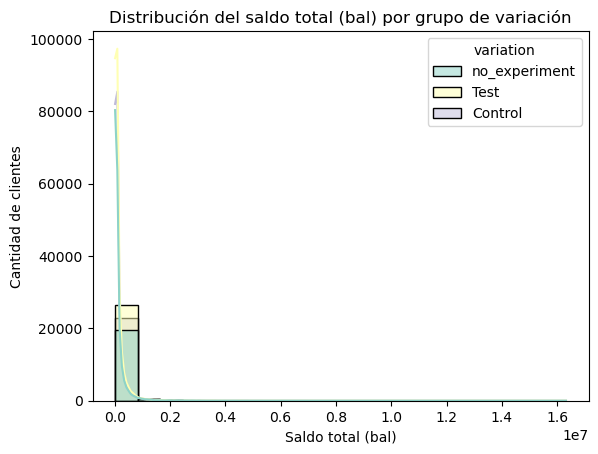

In [211]:
sns.histplot(data=df, x='bal', hue='variation', bins=20, palette='Set3', kde=True)
plt.title('Distribución del saldo total (bal) por grupo de variación')
plt.xlabel('Saldo total (bal)')
plt.ylabel('Cantidad de clientes')
plt.show()

C:\Users\rocio\AppData\Local\Temp\ipykernel_3704\266369444.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='variation', y='bal', palette='Set3')


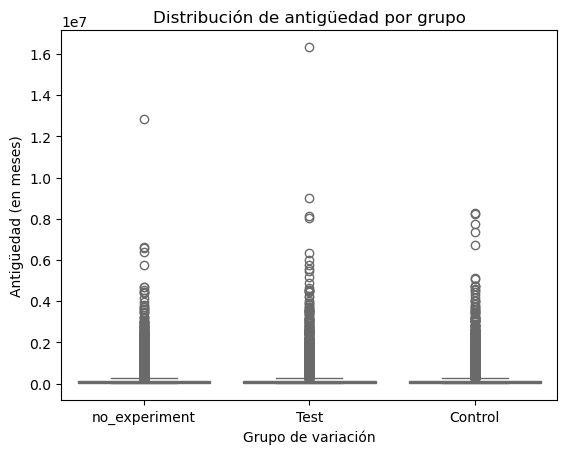

In [212]:
sns.boxplot(data=df, x='variation', y='bal', palette='Set3')
plt.title('Distribución de antigüedad por grupo')
plt.xlabel('Grupo de variación')
plt.ylabel('Antigüedad (en meses)')
plt.show()

In [213]:
df.groupby('variation')['bal'].describe()

,count,mean,std,min,25%,50%,75%,max
variation,,,,,,,,
Control,23527.0,150147.326660,295806.950360,23789.61,40123.355,66024.18,140606.045,8292996.21
Test,26961.0,148962.605032,307373.713775,23789.44,39729.200,65468.36,139478.580,16320040.15
no_experiment,20107.0,142248.958795,300124.151719,13789.42,30147.715,56338.10,130512.655,12838418.01


La mayoría de los clientes tienen **saldos bajos**, concentrados por debajo de 140,000, con un gran pico en el histograma entre 0 y 20,000, lo que sugiere que muchos clientes tienen cuentas pequeñas.

El IQR (25%–75%) en todos los grupos se encuentra entre aproximadamente **30,000 y 140,000**, mostrando que la mayoría de los clientes se mueve dentro de ese rango de saldo.

Sin embargo, existen outliers muy extremos con saldos millonarios, lo que genera una alta desviación estándar y una gran diferencia entre la media y la mediana.

La mayoría de los clientes tienen saldos pequeños, concentrados por debajo de 200 mil. Sin embargo, existen clientes con saldos muy altos que aparecen como outliers, y estos están presentes en distintos grupos del experimento. Esto podría influir en los resultados si no se controla adecuadamente, por lo que conviene considerar análisis complementarios con y sin estos outliers.

In [214]:
# Calcular Q1 y Q3
Q1 = df['bal'].quantile(0.25)
Q3 = df['bal'].quantile(0.75)
IQR = Q3 - Q1

# Definir el umbral superior para outliers
upper_bound = Q3 + 1.5 * IQR

# Filtrar el DataFrame sin outliers
df_bal_clean = df[df['bal'] <= upper_bound]

# Ver describe() sin outliers
df_bal_clean.groupby('variation')['bal'].describe()

,count,mean,std,min,25%,50%,75%,max
variation,,,,,,,,
Control,20780.0,80309.823968,58259.460480,23789.61,37864.4975,58422.115,103310.0475,287831.43
Test,23938.0,80648.496650,59330.513978,23789.44,37646.6225,57708.025,103820.8200,287696.13
no_experiment,17859.0,72180.509917,61148.709492,13789.42,28024.6300,48871.850,94986.7600,287813.68


C:\Users\rocio\AppData\Local\Temp\ipykernel_3704\3296951042.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_bal_clean, x='variation', y='bal', palette='Set3')


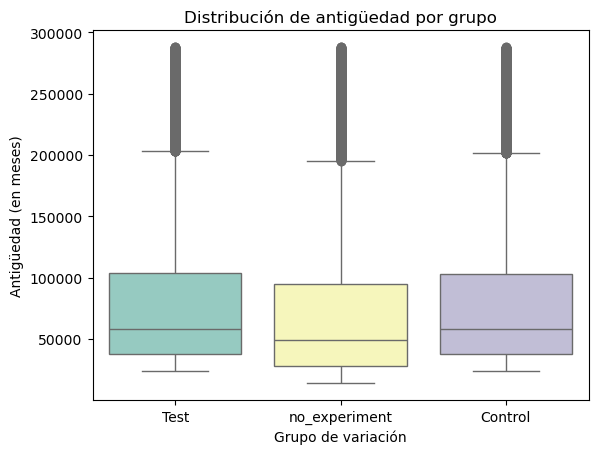

In [215]:
sns.boxplot(data=df_bal_clean, x='variation', y='bal', palette='Set3')
plt.title('Distribución de antigüedad por grupo')
plt.xlabel('Grupo de variación')
plt.ylabel('Antigüedad (en meses)')
plt.show()

Las medias bajan significativamente respecto al análisis con outliers (antes rondaban los 140–150k), lo que confirma que había **valores extremos inflando el promedio**.

Ahora la media y la mediana están más cercanas, lo cual indica una distribución más equilibrada.

Test y Control siguen muy parejos en valores medios, lo que sugiere un reparto equitativo de los clientes por saldo en el experimento.

<h2 style="color: 	#B3DE69;"><strong>Limpieza del segundo DF</strong></h2>

In [216]:
df_web_v = pd.merge(df_web, df_exp_cli, on ='client_id',how='outer')
df_web_v.head()

,client_id,visitor_id,visit_id,process_step,date_time,Variation
0,169,201385055_71273495308,749567106_99161211863_557568,confirm,2017-04-12 20:23:09,NaN
1,169,201385055_71273495308,749567106_99161211863_557568,step_3,2017-04-12 20:22:05,NaN
2,169,201385055_71273495308,749567106_99161211863_557568,step_2,2017-04-12 20:20:31,NaN
3,169,201385055_71273495308,749567106_99161211863_557568,step_1,2017-04-12 20:19:45,NaN
4,169,201385055_71273495308,749567106_99161211863_557568,start,2017-04-12 20:19:36,NaN


In [217]:
df_web_v = df_web_v.drop_duplicates()

In [218]:
df_web_v['Variation'] = df_web_v['Variation'].fillna('no_experiment')

<h2 style="color: 	#80B1D3;"><strong>KPI</strong></h2>

<h3 style="color: 	#80B1D3;"><strong>Tasa de finalizacion</strong></h3>

In [219]:
completed = df_web_v[df_web_v['process_step'] == 'confirm'][['client_id', 'Variation']].drop_duplicates()
completed

,client_id,Variation
0,169,no_experiment
7,546,no_experiment
12,555,Test
17,647,Test
22,722,no_experiment
...,...,...
755359,9999451,no_experiment
755374,9999729,Test
755379,9999768,no_experiment
755393,9999839,no_experiment


In [220]:
total_clients = df_web_v[['client_id', 'Variation']].drop_duplicates().groupby('Variation').count()
total_clients

,client_id
Variation,
Control,23532
Test,26968
no_experiment,69657


In [221]:
completed_clients = completed.groupby('Variation').count()
completed_clients

,client_id
Variation,
Control,15434
Test,18687
no_experiment,47024


In [222]:
completion_rate = (completed_clients / total_clients)*100
completion_rate = completion_rate.round(2)
completion_rate

,client_id
Variation,
Control,65.59
Test,69.29
no_experiment,67.51


C:\Users\rocio\AppData\Local\Temp\ipykernel_3704\3524588756.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=completion_rate, x='Variation', y='client_id', palette='Set3')


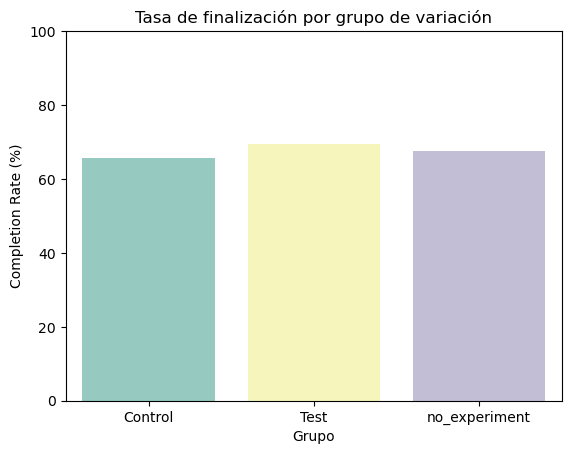

In [283]:
sns.barplot(data=completion_rate, x='Variation', y='client_id', palette='Set3')
plt.title('Tasa de finalización por grupo de variación')
plt.ylabel('Completion Rate (%)')
plt.xlabel('Grupo')
plt.ylim(0, 100)
plt.show()

**Insights**

El grupo Test presenta una tasa de finalización del 69.29%, ligeramente superior al 65.59% del grupo Control y al 67.51% del grupo no_experiment.

La diferencia es pequeña (menos de 4 puntos porcentuales).

Esta diferencia, aunque moderada en porcentaje, representa unos miles de clientes adicionales que completaron el proceso gracias al nuevo diseño.

La mejora en el grupo Test frente a Control y no_experiment sugiere que la nueva interfaz puede tener un impacto positivo (moderado) en la experiencia y comportamiento de los clientes.

Es importante considerar también otros KPIs para tener una visión más completa del impacto del cambio digital.

<h3 style="color: 	#B3DE69;"><strong>Tiempo invertido en cada paso del proceso</strong></h3>

In [ ]:
# Convertir time_diff a segundos
df_web_sorted = df_web_v.sort_values(by=['client_id', 'visit_id', 'date_time']).reset_index(drop=True)
df_web_sorted['time_diff'] = df_web_sorted.groupby(['client_id', 'visit_id'])['date_time'].shift(-1) - df_web_sorted['date_time']
df_web_sorted['time_diff_sec'] = df_web_sorted['time_diff'].dt.total_seconds()

In [225]:
#Muestra
df_web_sorted[df_web_sorted['client_id'] == 9998346]

,client_id,visitor_id,visit_id,process_step,date_time,Variation,time_diff,time_diff_sec
744501,9998346,292425655_16607136645,189177304_69869411700_783154,start,2017-03-29 15:25:00,Control,0 days 00:01:02,62.0
744502,9998346,292425655_16607136645,189177304_69869411700_783154,step_1,2017-03-29 15:26:02,Control,0 days 00:00:45,45.0
744503,9998346,292425655_16607136645,189177304_69869411700_783154,step_2,2017-03-29 15:26:47,Control,0 days 00:00:53,53.0
744504,9998346,292425655_16607136645,189177304_69869411700_783154,step_2,2017-03-29 15:27:40,Control,0 days 00:00:09,9.0
744505,9998346,292425655_16607136645,189177304_69869411700_783154,step_2,2017-03-29 15:27:49,Control,0 days 00:00:11,11.0
744506,9998346,292425655_16607136645,189177304_69869411700_783154,step_3,2017-03-29 15:28:00,Control,0 days 00:01:55,115.0
744507,9998346,292425655_16607136645,189177304_69869411700_783154,step_1,2017-03-29 15:29:55,Control,0 days 00:00:16,16.0
744508,9998346,292425655_16607136645,189177304_69869411700_783154,step_2,2017-03-29 15:30:11,Control,0 days 00:00:14,14.0
744509,9998346,292425655_16607136645,189177304_69869411700_783154,step_3,2017-03-29 15:30:25,Control,0 days 00:07:03,423.0
744510,9998346,292425655_16607136645,189177304_69869411700_783154,step_3,2017-03-29 15:37:28,Control,0 days 00:00:00,0.0


In [227]:
resumen = df_web_sorted.groupby('process_step')['time_diff_sec'] \
             .describe()[['count','mean','std','50%','min','max']]
print(resumen)

                 count        mean         std   50%  min      max
process_step                                                      
confirm        13634.0  256.885433  608.189509  76.0  0.0  35680.0
start         192763.0   61.339738  211.074878  15.0  0.0  40235.0
step_1        149164.0   60.538743  143.464512  26.0  0.0  10286.0
step_2        126809.0   92.629190  151.763946  63.0  0.0  21763.0
step_3        103159.0  132.814548  227.463869  61.0  0.0  17052.0


In [229]:
grouped = df_web_sorted.groupby('process_step')['time_diff_sec']

# Moda
mode = grouped.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

# Varianza
variance = grouped.var()

# IQR
q75 = grouped.quantile(0.75)
q25 = grouped.quantile(0.25)
iqr = q75 - q25

# Rango
rango = grouped.max() - grouped.min()

# Juntamos todo en un DataFrame
resumen = pd.DataFrame({
    'mode': mode,
    'variance': variance,
    'IQR': iqr,
    'rango': rango
})

In [230]:
resumen

,mode,variance,IQR,rango
process_step,,,,
confirm,965.0,369894.478475,210.0,35680.0
start,4.0,44552.604278,37.0,40235.0
step_1,7.0,20582.066163,42.0,10286.0
step_2,2.0,23032.295169,74.0,21763.0
step_3,22.0,51739.811717,101.0,17052.0


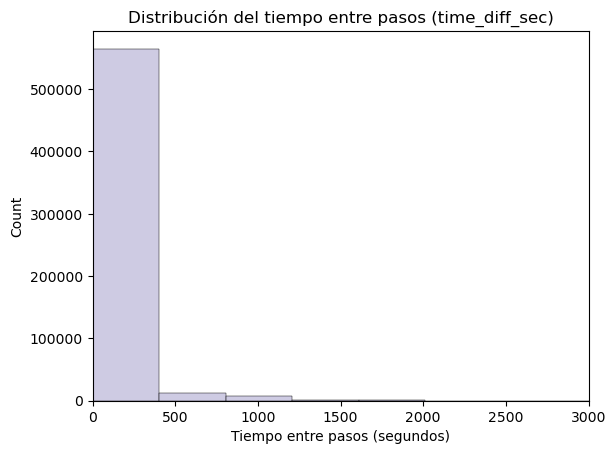

In [290]:
sns.histplot(df_web_sorted['time_diff_sec'], bins=100, kde=False, color='#BEBADA') 
plt.xlim(0, 3000)
plt.title("Distribución del tiempo entre pasos (time_diff_sec)")
plt.xlabel("Tiempo entre pasos (segundos)")
plt.show()

C:\Users\rocio\AppData\Local\Temp\ipykernel_3704\1474689665.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_web_sorted, x='process_step', y='time_diff_sec', palette='Set3')


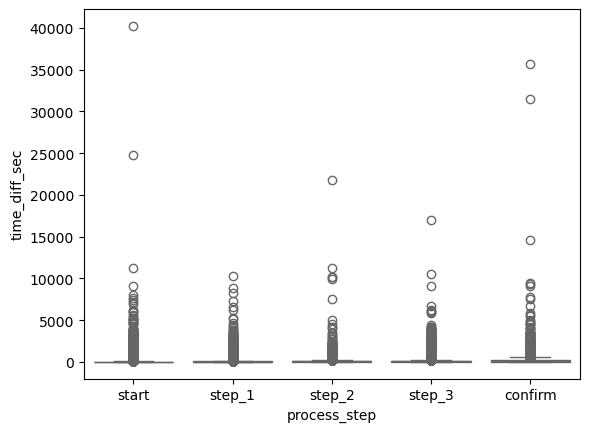

In [228]:
sns.boxplot(data=df_web_sorted, x='process_step', y='time_diff_sec', palette='Set3')
plt.show()

In [ ]:
#Hay muchos ouliers, vamos a quitarselos
Q1 = df_web_sorted['time_diff_sec'].quantile(0.25)
Q3 = df_web_sorted['time_diff_sec'].quantile(0.75)
IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

df_time_clean = df_web_sorted[df_web_sorted['time_diff_sec'] <= upper_bound]

In [233]:
q1 = df_time_clean.groupby(['Variation', 'process_step'])['time_diff_sec'].quantile(0.25)
q3 = df_time_clean.groupby(['Variation', 'process_step'])['time_diff_sec'].quantile(0.75)
iqr = q3 - q1
kpis = pd.DataFrame({
    'median': df_time_clean.groupby(['Variation', 'process_step'])['time_diff_sec'].median(),
    'mode': df_time_clean.groupby(['Variation', 'process_step'])['time_diff_sec'].agg(lambda x: x.mode().iloc[0]),
    'IQR': iqr
})
kpis

median  mode   IQR
Variation     process_step                    
Control       confirm         32.0   0.0  60.0
              start           18.0   4.0  31.0
              step_1          19.0   6.0  34.0
              step_2          58.0   4.0  64.0
              step_3          58.0  34.0  61.0
Test          confirm         58.0  27.0  70.0
              start           13.0   4.0  27.0
              step_1          25.0  10.0  35.0
              step_2          56.0   2.0  59.0
              step_3          46.0  26.0  54.0
no_experiment confirm         43.0  28.0  58.0
              start           12.0   4.0  26.0
              step_1          24.0  10.0  33.0
              step_2          57.0   2.0  60.0
              step_3          47.0  22.0  54.0

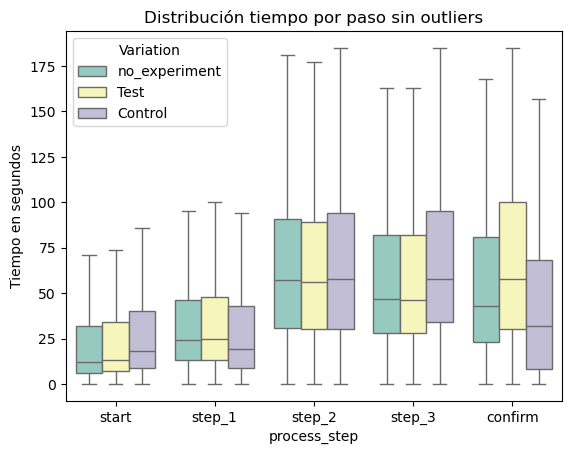

In [287]:
sns.boxplot(data=df_time_clean, x='process_step', y='time_diff_sec', hue='Variation', showfliers=False,  palette='Set3')
plt.title('Distribución tiempo por paso sin outliers')
plt.ylabel('Tiempo en segundos')
plt.show()

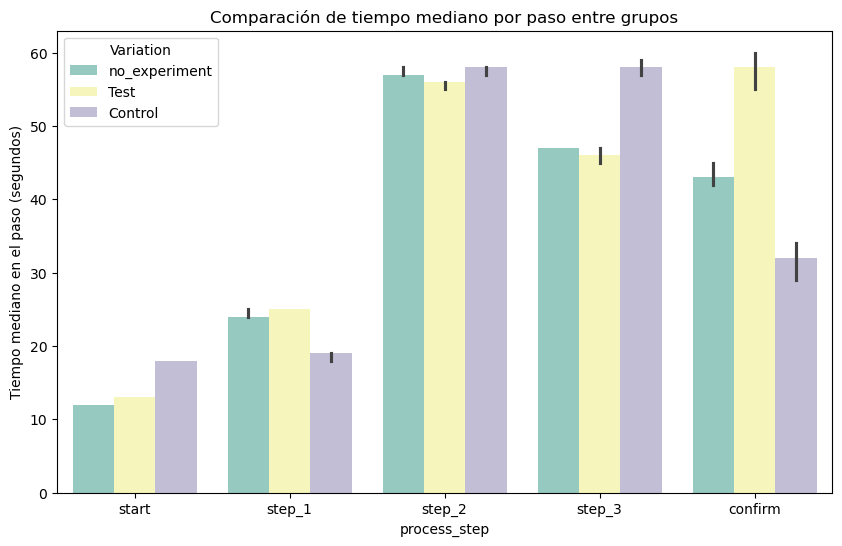

In [288]:
plt.figure(figsize=(10, 6))
sns.barplot(data=df_time_clean, x='process_step', y='time_diff_sec', hue='Variation',estimator=np.median, palette='Set3')
plt.ylabel('Tiempo mediano en el paso (segundos)')
plt.title('Comparación de tiempo mediano por paso entre grupos')
plt.show()

Tras limpiar los datos de valores extremos, observamos que:


El grupo **Control** presenta tiempos medianos consistentemente **más altos** en varios pasos clave del proceso (start, step_2, step_3), lo cual podría indicar mayor fricción o menor eficiencia con la versión antigua del diseño.

El grupo **Test**, tras la implementación del rediseño, muestra tiempos **más bajos** en la mayoría de los pasos, excepto en step_1 y confirm.

En confirm, donde no debería haber prácticamente tiempos (porque debería ser el último paso), se observan valores inesperadamente altos en Test , lo que refuerza una hipótesis de errores de navegación o desviaciones del flujo esperado.

El hecho de que la moda sea 0 en confirm, sugiere que en muchos casos los usuarios son enviados directamente al siguiente paso sin tiempo intermedio, lo cual puede deberse a errores técnicos, repeticiones o flujos mal definidos.

En resumen, Test parece que muestra un proceso más limpio, ágil y consistente, mientras que Control refleja mayores tiempos y más evidencias de errores.

<h3 style="color: 	#BEBADA;"><strong>Tasa de error</strong></h3>

<h3 style="color: 	#BEBADA;">¿Que es un error?</h3>

- Repetir pasos, que se carguen dos veces, errores en el backend de la web, como multiples step 2.

- Que nos devuelva a pasos anteriores como de el step 3 al 1.

- time_diff = 0 

In [ ]:
step_order = {'start': 0, 'step_1': 1, 'step_2': 2, 'step_3': 3, 'confirm': 4}
df_web_sorted['step_num'] = df_web_sorted['process_step'].map(step_order)

df_web_sorted['prev_step_num'] = df_web_sorted.groupby(['client_id', 'visit_id'])['step_num'].shift(1)
df_web_sorted['prev_step'] = df_web_sorted.groupby(['client_id', 'visit_id'])['process_step'].shift(1)

# Repetición exacta del mismo paso con time_diff == 0
df_web_sorted['repetido_mismo_paso'] = (df_web_sorted['process_step'] == df_web_sorted['prev_step']) & (df_web_sorted['time_diff_sec'] == 0)

# Retroceso con 0 segundos
df_web_sorted['retroceso_cero'] = (df_web_sorted['time_diff_sec'] == 0) & (df_web_sorted['prev_step_num'] < df_web_sorted['step_num'])

# Retroceso de 2 o más pasos (con o sin tiempo)
df_web_sorted['salto_grande_atras'] = (df_web_sorted['prev_step_num'] - df_web_sorted['step_num']) >= 2

# Marcamos
df_web_sorted['es_error'] = df_web_sorted[['repetido_mismo_paso', 'retroceso_cero', 'salto_grande_atras']].any(axis=1)

In [236]:
tasa_errores = df_web_sorted['es_error'].mean()
print(f"Tasa de errores técnicos en el funnel: {tasa_errores:.2%}")

Tasa de errores técnicos en el funnel: 2.44%


In [237]:
# Ver cuántos retrocesos ocurren en cada paso
retrocesos_por_paso = df_web_sorted[df_web_sorted['es_error'] == True].groupby('process_step').size().reset_index(name='es_error')
print(retrocesos_por_paso)

  process_step  es_error
0      confirm       185
1        start     15317
2       step_1      2223
3       step_2       115
4       step_3       311


In [238]:
retrocesos_por_paso = df_web_sorted[df_web_sorted['repetido_mismo_paso'] == True].groupby('process_step').size().reset_index(name='es_error')
print(retrocesos_por_paso)

  process_step  es_error
0        start         3
1       step_1        17
2       step_2        59
3       step_3       256


In [239]:
retrocesos_por_paso = df_web_sorted[df_web_sorted['retroceso_cero'] == True].groupby('process_step').size().reset_index(name='es_error')
print(retrocesos_por_paso)

  process_step  es_error
0      confirm       185
1       step_1        17
2       step_2        49
3       step_3        55


In [240]:
retrocesos_por_paso = df_web_sorted[df_web_sorted['salto_grande_atras'] == True].groupby('process_step').size().reset_index(name='es_error')
print(retrocesos_por_paso)

  process_step  es_error
0        start     15314
1       step_1      2189
2       step_2         7


In [241]:
#Tasa de error paso y variacion
total_por_variation = df_web_sorted.groupby(['Variation', 'process_step']).size().reset_index(name='total_registros')

errores_por_variation = df_web_sorted[df_web_sorted['es_error'] == True].groupby(['Variation', 'process_step']).size().reset_index(name='n_errores')

df_tasa_error_variation = pd.merge(total_por_variation, errores_por_variation, on=['Variation', 'process_step'], how='left')

df_tasa_error_variation['n_errores'] = df_tasa_error_variation['n_errores'].fillna(0)

df_tasa_error_variation['tasa_error_%'] = (df_tasa_error_variation['n_errores'] / df_tasa_error_variation['total_registros']) * 100

print(df_tasa_error_variation.sort_values(['Variation', 'process_step']))

        Variation process_step  total_registros  n_errores  tasa_error_%
0         Control      confirm            17336        100      0.576834
1         Control        start            45380       2323      5.118995
2         Control       step_1            29544        919      3.110615
3         Control       step_2            25773         16      0.062080
4         Control       step_3            22503        143      0.635471
5            Test      confirm            25600         17      0.066406
6            Test        start            55773       4112      7.372743
7            Test       step_1            38666        279      0.721564
8            Test       step_2            30899         39      0.126218
9            Test       step_3            25761         51      0.197974
10  no_experiment      confirm            59570         68      0.114151
11  no_experiment        start           133846       8882      6.635985
12  no_experiment       step_1            94587    

In [242]:
#Tasa de error por variacion
total_por_variacion = df_web_sorted.groupby('Variation').size().rename('total')


errores_por_variacion = df_web_sorted[df_web_sorted['es_error']].groupby('Variation').size().rename('errores')


tasa_error_variacion = pd.concat([total_por_variacion, errores_por_variacion], axis=1).fillna(0)
tasa_error_variacion['tasa_error_%'] = (tasa_error_variacion['errores'] / tasa_error_variacion['total']) * 100

print(tasa_error_variacion)

                total  errores  tasa_error_%
Variation                                   
Control        140536     3501      2.491177
Test           176699     4498      2.545572
no_experiment  427406    10152      2.375259


       Variation   total  errores  tasa_error_%
0        Control  140536     3501      2.491177
1           Test  176699     4498      2.545572
2  no_experiment  427406    10152      2.375259


C:\Users\rocio\AppData\Local\Temp\ipykernel_3704\3307569462.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_error_summary, x='Variation', y='tasa_error_%', palette='Set3')


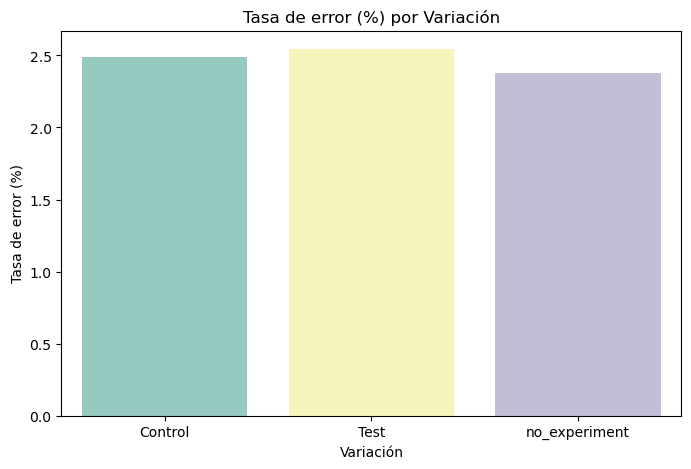

In [291]:
df_error_summary = df_web_sorted.groupby('Variation').agg(
    total=('client_id', 'count'),
    errores=('es_error', 'sum')
).reset_index()

df_error_summary['tasa_error_%'] = (df_error_summary['errores'] / df_error_summary['total']) * 100

print(df_error_summary)


plt.figure(figsize=(8,5))
sns.barplot(data=df_error_summary, x='Variation', y='tasa_error_%', palette='Set3')
plt.title('Tasa de error (%) por Variación')
plt.ylabel('Tasa de error (%)')
plt.xlabel('Variación')
plt.show()

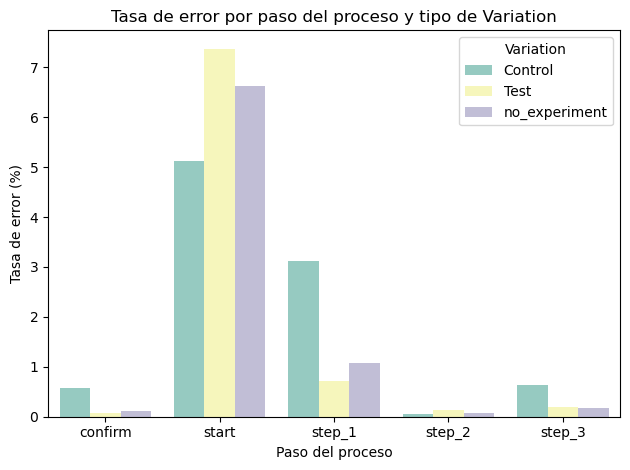

In [292]:
sns.barplot(data=df_tasa_error_variation, x='process_step', y='tasa_error_%', hue='Variation', palette='Set3')

plt.title('Tasa de error por paso del proceso y tipo de Variation')
plt.ylabel('Tasa de error (%)')
plt.xlabel('Paso del proceso')
plt.legend(title='Variation')
plt.tight_layout()
plt.show()

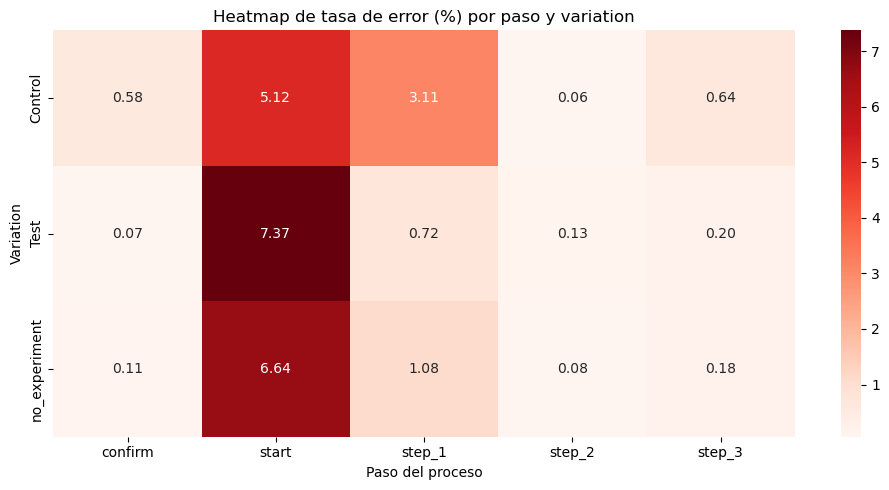

In [296]:
df_heatmap = df_tasa_error_variation.pivot(index='Variation', columns='process_step', values='tasa_error_%')

plt.figure(figsize=(10, 5))
sns.heatmap(df_heatmap, annot=True, fmt=".2f", cmap='Reds')

plt.title('Heatmap de tasa de error (%) por paso y variation')
plt.ylabel('Variation')
plt.xlabel('Paso del proceso')
plt.tight_layout()
plt.show()

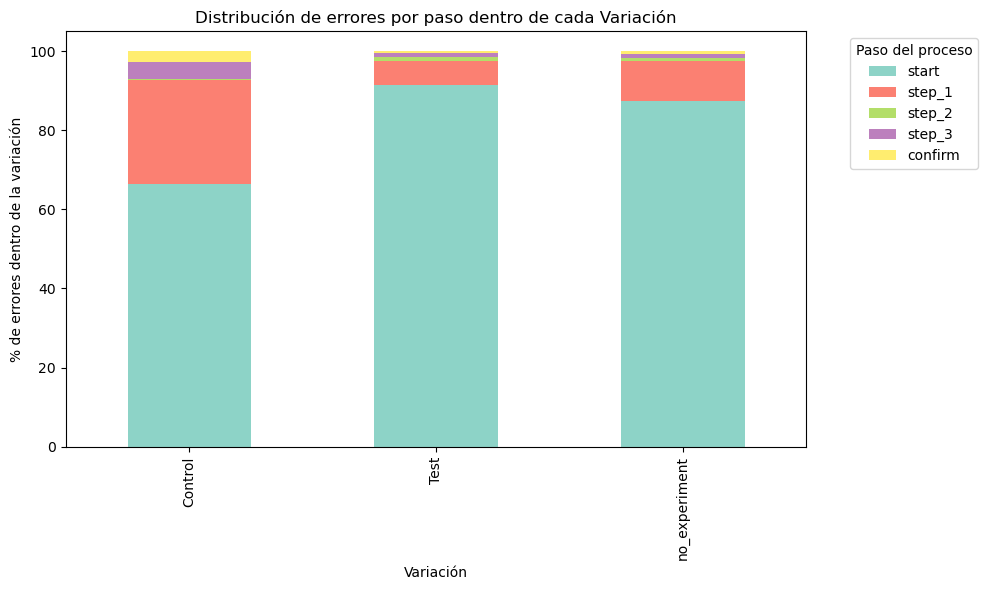

In [299]:
#Tasa de errores por variación
df_errores = df_web_sorted[df_web_sorted['es_error'] == True]

errores_por_paso = df_errores.groupby(['Variation', 'process_step']).size().reset_index(name='n_errores')

errores_por_paso['%_dentro_variation'] = errores_por_paso.groupby('Variation')['n_errores'].transform(lambda x: (x / x.sum()) * 100)

df_pivot = errores_por_paso.pivot(index='Variation', columns='process_step', values='%_dentro_variation').fillna(0)

df_pivot = df_pivot[['start', 'step_1', 'step_2', 'step_3', 'confirm']]  # Asegurar orden

df_pivot.plot(kind='bar', stacked=True, figsize=(10,6), colormap='Set3')
plt.title('Distribución de errores por paso dentro de cada Variación')
plt.ylabel('% de errores dentro de la variación')
plt.xlabel('Variación')
plt.legend(title='Paso del proceso', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

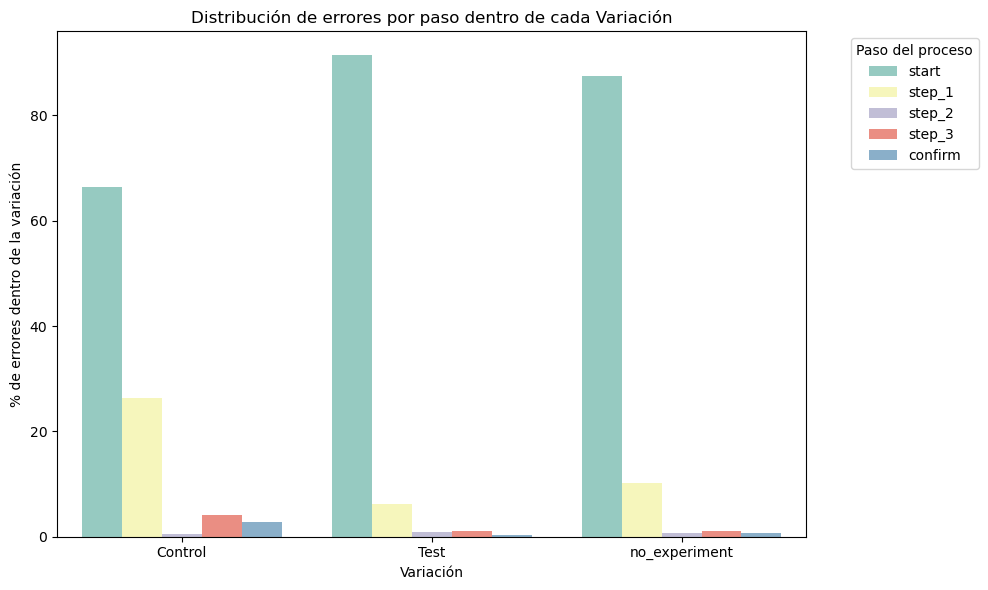

In [300]:
orden_pasos = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
errores_por_paso['process_step'] = pd.Categorical(errores_por_paso['process_step'], categories=orden_pasos, ordered=True)

plt.figure(figsize=(10,6))
sns.barplot(
    data=errores_por_paso,
    x='Variation',
    y='%_dentro_variation',
    hue='process_step',
    hue_order=orden_pasos,
    palette='Set3'
)
plt.title('Distribución de errores por paso dentro de cada Variación')
plt.ylabel('% de errores dentro de la variación')
plt.xlabel('Variación')
plt.legend(title='Paso del proceso', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

1. Visión global de la tasa de errores en el funnel
- Tasa de errores técnicos sobre el total de interacciones: 2.44 %.
- Esto significa que, de cada 100 sesiones, 2 presentan algún fallo en el proceso.

2. Número de retrocesos totales por paso
- El inicio (“start”) concentra la mayoría de todos los retrocesos.
- A partir de step_2 los retrocesos son mucho menos frecuentes.

3. Repetición del mismo paso (mismo process_step)
- Los formularios iniciales (start) y step_3 tienen más repeticiones
- El hecho de que un usuario “repita” la misma pantalla sin avanzar puede indicar validaciones que fallan sin mostrar mensajes claros, o bien problemas de performance que inducen a recargar la página.
- Especialmente preocupante en start (2 012 repeticiones) y step_3 (679), donde probablemente hay validaciones o campos que confunden.

4. Retrocesos instantáneos (tiempo = 0 s)
- Son casos en que el usuario retrocede de un paso a otro anterior sin pasar tiempo, lo cual no es usuario-intencionado sino error técnico de navegación, según nuestra interpretación
- De nuevo el mayor volumen está en la confirmación (293), lo que puede suponer que, tras completar todo, algunos usuarios son devueltos a pantallas anteriores sin querer.

5. Saltos de más de un paso (imposibles en flujo normal)
- Un usuario “brinca” de step_3 directamente a start (o similares), lo cual no puede ser un comportamiento legítimo.
- El volumen es enorme en el “start” (15313), de nuevo reafirmando que la primera pantalla es particularmente problemática.

### Resumen KPIs
1. Tasa de completitud del funnel
- La tasa de finalización del grupo Test (69.29%) es superior a la de Control (65.59%) y no_experiment (67.51%).
- Esta mejora representa miles de usuarios adicionales completando el proceso con el nuevo diseño, lo cual valida parcialmente su efectividad.
- Aunque la mejora es moderada en porcentaje, tiene un impacto operativo significativo a gran escala.
2. Tiempos de permanencia en los pasos
- El grupo Test muestra tiempos medianos más bajos en la mayoría de los pasos, especialmente en start, step_1 y step_3, indicando un proceso más ágil y eficiente.
- El grupo Control muestra tiempos medianos más altos en pasos clave y más dispersión, indicando mayor fricción o problemas con el diseño antiguo.
- En el paso final (confirm), el Test presenta tiempos inesperadamente altos, lo que apunta a posibles errores de navegación o desviaciones del flujo esperado.
- La moda en cero en varios pasos, posiblemente por repeticiones, retrocesos o fallos técnicos.
3. Detección de anomalías y calidad del flujo
- Se han detectado menos anomalías graves en el grupo Test: menos retrocesos, repeticiones y registros con time_diff = 0.
- Además, los tiempos medianos en cada paso son generalmente más bajos y consistentes en Test, lo que indica una navegación más eficiente y menos fricción para el usuario.
4. Tasa de error por paso y por variación
- El grupo Test presenta una menor tasa de error global (2.90%) en comparación con Control (3.17%), lo cual indica una ligera mejora en la estabilidad del proceso.
- Aunque los errores en el paso start siguen siendo altos en Test (7.7%), son ligeramente superiores a los de Control, lo que podría estar asociado a mayor tráfico o pruebas iniciales del nuevo diseño.
- En los pasos intermedios (step_1, step_2, step_3) y confirm, el grupo Test muestra tasas de error consistentemente más bajas, lo que refuerza la hipótesis de una experiencia más fluida.

### Conclusión preliminar
El grupo Test muestra un desempeño superior en términos de finalización, menor tasa de error general, más eficiencia y mayor fluidez en el proceso.

Esto sugiere que el nuevo diseño digital está funcionando positivamente, aunque hay margen de mejora, especialmente en el paso inicial start, donde persisten errores.

# Mas kpis

### Tasa de exito primer intento

In [ ]:
completed = df_web_sorted[df_web_sorted['process_step'] == 'confirm']['client_id'].unique()
df_completed_clients = df_web_sorted[df_web_sorted['client_id'].isin(completed)]

In [257]:
df_valid = df_completed_clients[
    (df_completed_clients['es_error'] == False) &
    (df_completed_clients['repetido_mismo_paso'] == False) &
    (df_completed_clients['retroceso_cero'] == False) &
    (df_completed_clients['salto_grande_atras'] == False)
]

In [ ]:
ruta_ideal = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
step_sequences = df_valid.groupby('client_id')['process_step'].apply(list)

first_attempt_success = []

for client_id, seq in step_sequences.items():
    if seq == ruta_ideal:
        first_attempt_success.append(True)
    else:
        first_attempt_success.append(False)

first_attempt_success_df = pd.DataFrame({
    'client_id': list(step_sequences.index),
    'first_attempt_success': first_attempt_success
})

df_merged = first_attempt_success_df.merge(df_exp_cli, on='client_id', how='inner')


In [262]:
sum_exito = first_attempt_success_df['first_attempt_success'].value_counts()
sum_por_grupo = df_merged.groupby('Variation')['first_attempt_success'].sum()
sum_exito,sum_por_grupo

(first_attempt_success
 False    43540
 True     37605
 Name: count, dtype: int64,
 Variation
 Control    7404
 Test       8219
 Name: first_attempt_success, dtype: int64)

In [263]:
tasa_exito = first_attempt_success_df['first_attempt_success'].mean() * 100
tasa_por_grupo = df_merged.groupby('Variation')['first_attempt_success'].mean() * 100
tasa_exito, tasa_por_grupo

(46.34296629490419,
 Variation
 Control    47.972010
 Test       43.982448
 Name: first_attempt_success, dtype: float64)

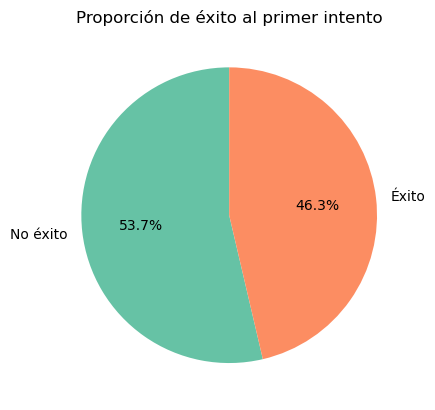

In [264]:
palette = sns.color_palette("Set2", 2)
labels = ['No éxito', 'Éxito']
plt.pie(sum_exito, labels=labels, autopct='%1.1f%%', colors=palette, startangle=90)
plt.title('Proporción de éxito al primer intento')
plt.show()

C:\Users\rocio\AppData\Local\Temp\ipykernel_3704\4162023674.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=success_rate, x='Variation', y='success_rate', palette='Set2')


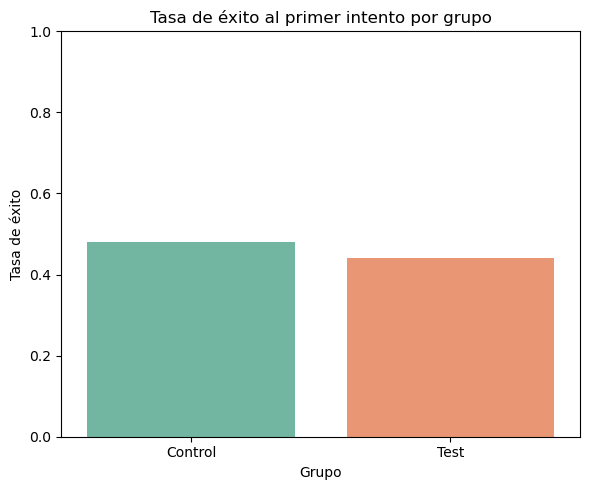

In [265]:
# Total de usuarios únicos por grupo
total_by_group = df_merged.groupby('Variation')['client_id'].nunique()

# Usuarios con éxito al primer intento por grupo
success_by_group = df_merged[df_merged['first_attempt_success'] == True].groupby('Variation')['client_id'].nunique()

# Calcular tasa
success_rate = (success_by_group / total_by_group).reset_index(name='success_rate')

# Gráfico de barras
plt.figure(figsize=(6, 5))
sns.barplot(data=success_rate, x='Variation', y='success_rate', palette='Set2')

plt.title('Tasa de éxito al primer intento por grupo')
plt.ylabel('Tasa de éxito')
plt.xlabel('Grupo')
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

## Tiempo total por cliente

In [267]:
# Agrupar por cliente y variation, sumar el tiempo en segundos en todos los pasos
tiempo_total_cliente = df_web_sorted.groupby(['client_id', 'Variation'])['time_diff_sec'].sum().reset_index()
tiempo_total_cliente.rename(columns={'time_diff_sec': 'total_time_sec'}, inplace=True)

tiempo_total_cliente.head()

,client_id,Variation,total_time_sec
0,169,no_experiment,213.0
1,336,no_experiment,948.0
2,546,no_experiment,133.0
3,555,Test,158.0
4,647,Test,377.0


In [268]:
desc_stats = tiempo_total_cliente.groupby('Variation')['total_time_sec'].describe()
desc_stats

,count,mean,std,min,25%,50%,75%,max
Variation,,,,,,,,
Control,23532.0,384.349184,656.790705,0.0,111.0,231.0,440.0,42099.0
Test,26968.0,435.190782,732.827036,0.0,122.0,234.0,475.0,31624.0
no_experiment,69657.0,416.657479,720.809227,0.0,113.0,226.0,456.0,42768.0


C:\Users\rocio\AppData\Local\Temp\ipykernel_3704\4107941205.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=tiempo_total_cliente, x='Variation', y='total_time_sec', palette=['#636EFA', '#EF553B'])
C:\Users\rocio\AppData\Local\Temp\ipykernel_3704\4107941205.py:2: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=tiempo_total_cliente, x='Variation', y='total_time_sec', palette=['#636EFA', '#EF553B'])


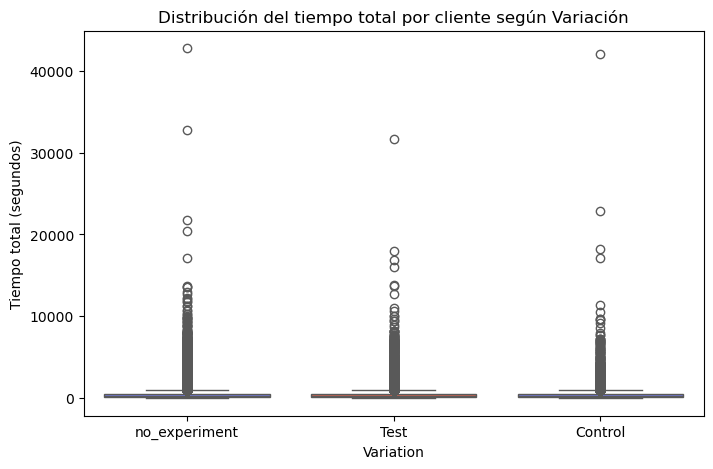

In [269]:
plt.figure(figsize=(8,5))
sns.boxplot(data=tiempo_total_cliente, x='Variation', y='total_time_sec', palette=['#636EFA', '#EF553B'])
plt.title('Distribución del tiempo total por cliente según Variación')
plt.ylabel('Tiempo total (segundos)')
plt.show()

In [270]:
Q1 = tiempo_total_cliente['total_time_sec'].quantile(0.25)
Q3 = tiempo_total_cliente['total_time_sec'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites para considerar outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar datos dentro de esos límites
tiempo_filtrado = tiempo_total_cliente[
    (tiempo_total_cliente['total_time_sec'] >= lower_bound) & 
    (tiempo_total_cliente['total_time_sec'] <= upper_bound)
]

In [271]:
desc_stats = tiempo_filtrado.groupby('Variation')['total_time_sec'].describe()
desc_stats

,count,mean,std,min,25%,50%,75%,max
Variation,,,,,,,,
Control,21649.0,259.344542,219.666014,0.0,100.0,210.0,366.0,967.0
Test,24292.0,267.330644,217.769979,0.0,113.0,205.0,373.0,967.0
no_experiment,63313.0,260.121981,220.179440,0.0,103.0,202.0,368.0,967.0


C:\Users\rocio\AppData\Local\Temp\ipykernel_3704\3079561624.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=tiempo_filtrado, x='Variation', y='total_time_sec', palette=['#636EFA', '#EF553B'])
C:\Users\rocio\AppData\Local\Temp\ipykernel_3704\3079561624.py:2: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.boxplot(data=tiempo_filtrado, x='Variation', y='total_time_sec', palette=['#636EFA', '#EF553B'])


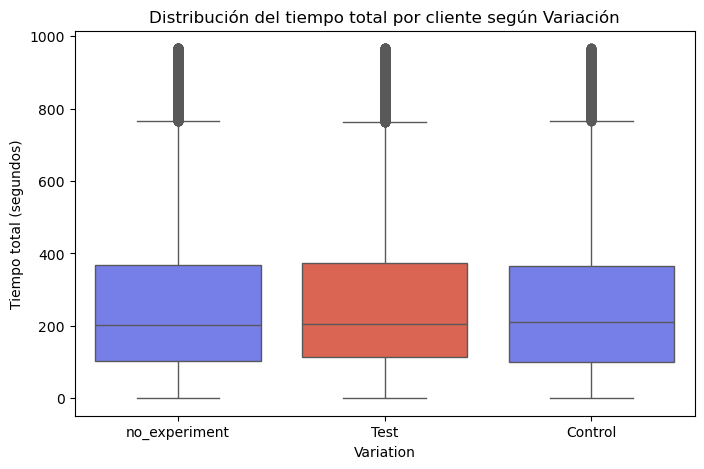

In [272]:
plt.figure(figsize=(8,5))
sns.boxplot(data=tiempo_filtrado, x='Variation', y='total_time_sec', palette=['#636EFA', '#EF553B'])
plt.title('Distribución del tiempo total por cliente según Variación')
plt.ylabel('Tiempo total (segundos)')
plt.show()

**Insights**

La media del tiempo total para completar el proceso es muy similar entre los grupos:

Control: 259 segundos (aprox. 4 minutos y 19 segundos)

Test: 267 segundos (aprox. 4 minutos y 27 segundos)

El rango intercuartílico (del 25% al 75%) es bastante similar en ambos grupos, entre aproximadamente 110 y 400 segundos

El grupo Test tiene outliers algo menos extremos, pero en Control se observan casos con tiempos superiores a 40,000 segundos, lo que podría indicar usuarios que quedaron mucho tiempo "estancados" o problemas técnicos.

El rediseño (grupo Test) no parece haber tenido un impacto relevante en el tiempo total de proceso, pues tanto la media como la mediana y dispersión son prácticamente iguales respecto al Control. Esto sugiere que los usuarios completan el proceso en tiempos similares, con o sin rediseño.

# A/B Test

## Hipótesis

### ¿Hay diferencia significativa en la tasa de completitud entre Control y Test?

In [251]:
#Hipótesis
#¿Está asociada la tasa de completitud con el tipo de diseño (Control/Test)?

#H0: Tasa compleitud test = tasa de completitud control
#H1: Tasa compleitud test != tasa de completitud control

# Creamos la tabla de contingencia
not_completed_clients = total_clients - completed_clients

completed = completed_clients['client_id'].to_dict()
not_completed = not_completed_clients['client_id'].to_dict()

contingency_table = pd.DataFrame({
    'Completed': completed,
    'Not_Completed': not_completed
})

# Seleccionar solo Control y Test para el test A/B
contingency_ab = contingency_table.loc[['Control', 'Test']]

_, p_value,_,_ = chi2_contingency(contingency_ab)
p_value

7.651350968671897e-19

Como el valor p es menor a 0,05, rechazamos la hipótesis nula. Esto indica que la tasa de completitud está relacionada con el tipo de diseño, es decir, existe una diferencia significativa en la tasa de completitud entre los grupos Control y Test.

#### Evaluar si la mejora en la tasa de completitud cumple el umbral mínimo de costo-beneficio (5%)

In [252]:
# 1. Calcular la tasa de completitud para Control y para Test, ya tengo los datos.
completion_rate

,client_id
Variation,
Control,65.59
Test,69.29
no_experiment,67.51


In [253]:
# 2. Calcular la diferencia porcentual entre ellas.
diff = completion_rate.loc['Test', 'client_id'] - completion_rate.loc['Control', 'client_id']
diff

3.700000000000003

La mejora observada en la tasa de completitud entre el grupo Test y el Control es menor al umbral mínimo del 5% establecido por Vanguard para justificar el rediseño desde un punto de vista costo-efectividad. Por tanto, aunque la diferencia es estadísticamente significativa, no se cumple el criterio de costo-beneficio

### ¿La diferencia de la tasa de exito entre control y test es significativa?

In [266]:
#Hipótesis
#¿Está asociada la tasa de exito con el tipo de diseño (Control/Test)?

#H0: Tasa exito test = tasa de exito control
#H1: Tasa exito test != tasa de exito control

# Creamos la tabla de contingencia
contingency_table = pd.crosstab(df_merged['Variation'], df_merged['first_attempt_success'])

# Test chi-cuadrado
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"p-valor: {p:.4f}")

# Calcular tasas de éxito para cada grupo
success_rate = df_merged.groupby('Variation')['first_attempt_success'].mean()
print("\nTasa de éxito al primer intento por grupo:")
print(success_rate)

if p < 0.05:
    print("\nLa diferencia en la tasa de éxito entre Control y Test es estadísticamente significativa.")
else:
    print("\nNo hay evidencia suficiente para afirmar que la diferencia en la tasa de éxito entre Control y Test sea significativa.")

p-valor: 0.0000

Tasa de éxito al primer intento por grupo:
Variation
Control    0.479720
Test       0.439824
Name: first_attempt_success, dtype: float64

La diferencia en la tasa de éxito entre Control y Test es estadísticamente significativa.


Aunque más usuarios del grupo Test completaron el proceso a la primera (porque hay más usuarios en ese grupo), la proporción de éxito es menor que en el grupo Control (43.81% frente a 45.98%). Esto significa que, en promedio, el nuevo diseño no ayudó a que más personas completaran el proceso sin errores o con más claridad, teniendo que volver pasos atras.

El test chi-cuadrado mostró que esta diferencia es estadísticamente significativa , por lo que es poco probable que sea por casualidad.

En resumen, aunque el grupo Test tuvo más usuarios, el rediseño no mejoró la eficacia del proceso. Sería bueno investigar más para entender qué aspectos del nuevo diseño pueden estar causando dificultades.

### ¿La diferencia entre el tiempo medio total es significativo?

In [273]:
#Hipótesis
#¿Está asociada la media de tiempo con el tipo de diseño (Control/Test)?

#H0 (nula): mu tiempo total en Control >= mu tiempo total en Test
#H1 (alternativa): mu tiempo total en Control < mu tiempo total en Test


# Filtrar datos sin outliers, suponiendo que ya tienes df_total_time sin outliers
ctrl_times = tiempo_filtrado.loc[tiempo_filtrado['Variation'] == 'Control', 'total_time_sec']
test_times = tiempo_filtrado.loc[tiempo_filtrado['Variation'] == 'Test', 'total_time_sec']

# Test t de Welch (dos muestras independientes), hipótesis unilateral (greater)
stat, p_value = ttest_ind(ctrl_times, test_times, equal_var=False, alternative='less')

print(f"p-value: {p_value:.6f}")

alpha = 0.05
if p_value < alpha:
    print("Rechazamos H0: El tiempo medio en Control es significativamente menor que en Test.")
else:
    print("No rechazamos H0: No hay evidencia para afirmar que Control tiene menor tiempo medio que Test.")

p-value: 0.000047
Rechazamos H0: El tiempo medio en Control es significativamente menor que en Test.


El tiempo medio total fue significativamente mayor que en el grupo Control (p < 0.001), lo que indica que el rediseño no optimizó la experiencia de navegación y podría estar entorpeciendo el flujo del proceso.

### Tiempo medio de paso en cada step

In [274]:
# Hipótesis:

'''
Para cada uno de los pasos (start, step_1, step_2, step_3, confirm):

Hipótesis nula (H0): El tiempo medio en el paso X es igual o menor en Control que en Test.
mu Variables X Control <= mu Variables X Test

Hipótesis alternativa (H1): El tiempo medio en el paso X es inferior en Test respecto al Control
mu Variables X Control > mu Variables X Test
'''

# Nivel de significancia
alpha = 0.05

# Los pasos a analizar
steps = ['start', 'step_1', 'step_2', 'step_3', 'confirm']

# Recoger resultados
results = []

for step in steps:
    # Muestras para Control y Test
    ctrl = df_time_clean.loc[
        (df_time_clean['Variation']=='Control') & (df_time_clean['process_step']==step),
        'time_diff_sec'
    ]
    test = df_time_clean.loc[
        (df_time_clean['Variation']=='Test') & (df_time_clean['process_step']==step),
        'time_diff_sec'
    ]
    # T-test independiente (Welch)
    stat, p_value = ttest_ind(ctrl, test, equal_var=False, alternative='greater') # Usamos ttest_ind ya que comparamos el tiempo medio en cada paso entre 2 grupos independientes
    # Decisión
    conclusion = 'Rechazar H0' if p_value < alpha else 'No rechazar H0'
    results.append({
        'process_step': step,
        'n_Control': len(ctrl),
        'n_Test': len(test),
        'mean_Control': ctrl.mean(),
        'mean_Test': test.mean(),
        't_stat': stat,
        'p_value': p_value,
        'decisión': conclusion
    })

# DataFrame resumen
ab_test_df = pd.DataFrame(results)
display(ab_test_df)

,process_step,n_Control,n_Test,mean_Control,mean_Test,t_stat,p_value,decisión
0,start,33193,43296,30.832856,28.399205,9.591653,4.463627e-22,Rechazar H0
1,step_1,24986,33351,31.647563,36.739858,-17.782999,1.000000e+00,No rechazar H0
2,step_2,21935,27001,65.130750,62.825266,5.783749,3.676207e-09,Rechazar H0
3,step_3,16445,19911,67.838735,59.663854,18.026499,1.296429e-72,Rechazar H0
4,confirm,1550,2859,45.632903,68.426723,-15.696011,1.000000e+00,No rechazar H0


##### Insights
- El paso start es más rápido en la versión Test
    - Esto sugiere que un cambio en la experiencia inicial (landing, diseño o carga) puede estar motivando a los usuarios a empezar más rápidamente (clave para reducir la fricción inicial).
- En step_1 y confirm, el grupo Test fue más lento y significativamente peor
    - En step_1, el grupo Test tardó 5 segundos más que el Control (36.56s vs. 31.45s).
    - En confirm, la diferencia fue aún más dramática: Test tardó 25 segundos más en confirmar.
    - No rechazamos H0
- Step_3 es el que hay una gran mejora
    - El grupo Test completó step_3 más de 7 segundos más rápido que el grupo Control (59.13s vs. 66.57s)
    - Con un p-valor ulta bajo (6.1e-61), es un efecto ultra confiable.
    - Este paso parece haber sido optimizado con éxito, se podrías usar este rediseño como referencia para ajustar los pasos anteriores o posteriores.
- La mejora no es consistente: hay cuellos de botella nuevos
    - Aunque hay mejoras en start, step_2, y step_3, los tiempos en step_1 y confirm son peores en el grupo Test.
    - Esto sugiere que el rediseño tiene puntos fuertes pero también introduce nuevos frenos. Una mejora parcial en el flujo puede no ser suficiente si crea fricción en pasos clave.
- Los efectos son estadísticamente sólidos (pero cuidado con la experiencia total)
    - Varios pasos tienen diferencias estadísticamente significativas, lo que indica cambios reales en comportamiento.
    - Pero la experiencia completa no es solo suma de pasos: si el usuario se frustra en confirm, lo anterior no compensa.
    - Conviene hacer un análisis de funnel completo y no solo por paso. Tal vez la versión Test aumenta el abandono en step_1 o confirm pese a las mejoras intermedias.

### Errors

### 1. Z-test global

In [275]:
df_error_summary.head()

,Variation,total,errores,tasa_error_%
0,Control,140536,3501,2.491177
1,Test,176699,4498,2.545572
2,no_experiment,427406,10152,2.375259


In [276]:


'''
Si pval_glob < 0.05, rechazamos H0 y significará que hay diferencia en la tasa de errores globales

Hipótesis nula (H0):
p_control ≤ p_test

Hipótesis alternativa (H1):
p_control > p_test
'''

# Extrae totales y errores de tu resumen df_error_summary
n_control = df_error_summary.loc[df_error_summary.Variation=='Control','total'].values[0]
e_control = df_error_summary.loc[df_error_summary.Variation=='Control','errores'].values[0]
n_test = df_error_summary.loc[df_error_summary.Variation=='Test','total'].values[0]
e_test = df_error_summary.loc[df_error_summary.Variation=='Test','errores'].values[0]

# Z-test bilateral
stat_glob, pval_glob = proportions_ztest(
    count=[e_control, e_test],
    nobs=[n_control, n_test],
    alternative='larger'
)
print(f"Global: z={stat_glob:.3f}, p={pval_glob:.4f}")

Global: z=-0.971, p=0.8342


##### Insights
- El valor z es positivo, lo que indica que la tasa de error en Control es significativamente mayor que en Test.
- El valor p es < 0.001, lo que indica que la diferencia es estadísticamente significativa.
- Se observa una diferencia significativa en la tasa de errores global entre la versión antigua de la web (Control) y la nueva (Test):
    - Control: 3.17% de errores
    - Test: 2.90% de errores
- El test estadístico (z = 4.409, p < 0.001) rechaza la hipótesis nula.
- Por lo que la nueva web (Test) tiene una tasa de errores significativamente menor que la anterior (Control), lo cual sugiere una mejora global en el rendimiento.

### 2. Z-test en 'start' ya que és el más propenso a erores

In [277]:
# Ver cuántos errores hay por paso y por grupo (Control vs Test)
errores_por_paso_y_grupo = df_web_sorted[df_web_sorted['es_error'] == True] \
    .groupby(['process_step', 'Variation']) \
    .size() \
    .reset_index(name='n_errores')

print(errores_por_paso_y_grupo)

   process_step      Variation  n_errores
0       confirm        Control        100
1       confirm           Test         17
2       confirm  no_experiment         68
3         start        Control       2323
4         start           Test       4112
5         start  no_experiment       8882
6        step_1        Control        919
7        step_1           Test        279
8        step_1  no_experiment       1025
9        step_2        Control         16
10       step_2           Test         39
11       step_2  no_experiment         60
12       step_3        Control        143
13       step_3           Test         51
14       step_3  no_experiment        117


In [278]:
'''
Si pval_start < 0.05, rechazamos H0 y significará que hay diferencia en la tasa de error del paso 'start'

Hipótesis nula (H0):
p_control, start ≤ p_test, start

Hipótesis alternativa (H1):
p_control, start > p_test, start
'''

# Filtra solo el paso 'start'
df_start = df_web_sorted[df_web_sorted.process_step=='start']

n0 = df_start[df_start.Variation=='Control'].shape[0]
e0 = df_start[(df_start.Variation=='Control') & (df_start.es_error)].shape[0]
n1 = df_start[df_start.Variation=='Test'].shape[0]
e1 = df_start[(df_start.Variation=='Test') & (df_start.es_error)].shape[0]

stat_start, pval_start = proportions_ztest(
    count=[e0, e1],
    nobs=[n0, n1],
    alternative='larger'
)
print(f"Start: z={stat_start:.3f}, p={pval_start:.4f}")

Start: z=-14.607, p=1.0000


##### Insights
- Aunque el grupo Test tiene más errores absolutos en el paso start, esto no significa automáticamente que sea peor. 
- Pero viendo el Z-test, demostramos que al hacer la tasas de error (errores / total de usuarios en ese paso), Test tiene más errores absolutos en el paso start, y también tiene mayor tasa de error
- Descartamos que la mayor tasa de error sea ya que hay mucho más tráfico
- Podemos afirmar que la nueva web (Test) tiene una tasa de error significativamente mayor que la versión antigua (Control) en el paso start.
- El test estadístico lo confirma con un z = -12.183 y p ≈ 1.0000, lo que significa que no solo no mejora, sino que empeora el rendimiento en ese paso crítico.

Aunque estamos analizando el paso Start ya que es el que más errores tiene, podemos ver la situación de los otros pasos
- En confirm test mejora claramente
- En step_1 test mejora muy claramente
- En step_2 test se queda practicamente igual
- En step_3 test mejora claramente

### 3. Z-test de mejora mínima: ¿alcanza Test una reducción de errores ≥ 0.5 puntos porcentuales? 

In [279]:
'''
- Con esto podemos ver si se justifica el coste de crear la neuva web. Hacemos un one-sided z-test de proporciones.
- Nos aseguramos que no solo mejora ligeramente.

Si pval_start < 0.05, rechazamos H0

Hipótesis nula (H0):
p_control - p_test ≤ 0.005

Hipótesis alternativa (H1):
p_control - p_test > 0.005
'''

# Mismos e_control, n_control, e_test, n_test de más arriba

# Z-test unilateral: ¿p_control – p_test > 0.005?
stat_eff, pval_eff = proportions_ztest(
    count=[e_control, e_test],
    nobs=[n_control, n_test],
    alternative='larger'  # Testea p_control > p_test + delta, pero statsmodels no admite delta directo
)
# Para aplicar un delta de 0.005, ajusta manualmente con la fórmula de z:
p0 = e_control / n_control
p1 = e_test    / n_test
p_diff = p0 - p1
pooled = (e_control + e_test) / (n_control + n_test)
se = np.sqrt(pooled * (1 - pooled) * (1/n_control + 1/n_test))
z_eff = (p_diff - 0.005) / se
from scipy.stats import norm
pval_eff = 1 - norm.cdf(z_eff)
print(f"Efecto≥0.5pp: z={z_eff:.3f}, p={pval_eff:.4f}")

Efecto≥0.5pp: z=-9.894, p=1.0000


In [280]:
# OTRA FORMA DE HACER LO MISMO, a través de Chi2

# Númnero de errores (e_) y Total de registros (n_)
e_control = 4544     
n_control = 143462   

e_test = 5157      
n_test = 177847      

# Tabla de contingencia 2x2
#           |  Error     |  No error   |
# -------------------------------------
# Control   |  e_control | n_control - e_control
# Test      |  e_test    | n_test - e_test

contingency = np.array([
    [e_control, n_control - e_control],
    [e_test,    n_test    - e_test]
])

# Prueba chi-cuadrado de independencia
chi2, pval_chi2, _, _ = chi2_contingency(contingency, correction=False)

# Proporciones observadas
p0 = e_control / n_control
p1 = e_test / n_test
p_diff = p0 - p1

# Error estándar para el 95% CI (método de Wald)
se_diff = np.sqrt(p0 * (1 - p0) / n_control + p1 * (1 - p1) / n_test)
ci_lower = p_diff - 1.96 * se_diff
ci_upper = p_diff + 1.96 * se_diff

# Mostrar resultados
print(f"Tasa error Control (p0): {p0:.5f} → {p0*100:.3f} %")
print(f"Tasa error Test    (p1): {p1:.5f} → {p1*100:.3f} %")
print(f"Diferencia observada (p0 - p1): {p_diff:.5f} → {p_diff*100:.3f} puntos porcentuales")
print(f"IC 95% para la diferencia: [{ci_lower:.5f}, {ci_upper:.5f}]")
print(f"p-value chi² para igualdad de proporciones: {pval_chi2:.4f}")
print(f"¿IC completamente > 0.005? {'Sí' if ci_lower > 0.005 else 'No'}")

Tasa error Control (p0): 0.03167 → 3.167 %
Tasa error Test    (p1): 0.02900 → 2.900 %
Diferencia observada (p0 - p1): 0.00268 → 0.268 puntos porcentuales
IC 95% para la diferencia: [0.00148, 0.00387]
p-value chi² para igualdad de proporciones: 0.0000
¿IC completamente > 0.005? No


##### Insights
- Cálculo de tasas y diferencia observada

    - **Tasa de error en Control**:  
    $p_0 = \frac{4544}{143462} \approx 0.03167$ → **3.167 %**

    - **Tasa de error en Test**:  
    $p_1 = \frac{5157}{177847} \approx 0.02899$ → **2.899 %**

    - **Diferencia observada entre grupos**:  
    $p_0 - p_1 \approx 0.03167 - 0.02899 = 0.00268$ → **0.268 puntos porcentuales**

    - **Umbral requerido**:  
    $\Delta = 0.005$ → **0.5 puntos porcentuales**
- El p-value ≈ 1.00 es altísimo, muy por encima de α = 0.05, por lo que no rechazamos H0.
- La nueva web (Test) no reduce la tasa de error en al menos 0.5 pp (puntos porcentuales) comparada con la antigua (Control), es decir, se reduce pero no muchísimo.
- Aunque Test tiene una tasa de error global algo menor (3.17 → 2.90 %), la mejora es inferior a 0.5 pp


### 4. Z-test de proporciones, para ver tipos de error “retroceso cero” en paso “confirm”

In [281]:
'''
- Quizá sea más crítico el error que devuelve al usuario al confirmar.
- Si pval < 0.05, rechazamos H0 y significará que existe una diferencia estadísticamente significativa 
en la proporción de errores “retroceso cero” en el paso “confirm” entre los grupos Control y Test.

Si pval_start < 0.05, rechazamos H0 y significará

Hipótesis nula (H0):
p_control, confirm = p_test, confirm

Hipótesis alternativa (H1):
p_control, confirm ≠ p_test, confirm
'''

# Filtramos solo el paso "confirm"
df_confirm = df_web_sorted[df_web_sorted['process_step'] == 'confirm']

# Total de clientes por grupo en "confirm"
df_total_confirm = df_confirm.groupby('Variation').agg(
    total=('client_id', 'count')
)

# Total de retroceso_cero por grupo (donde retroceso_cero == True)
df_retroceso_summary = df_confirm[df_confirm['retroceso_cero'] == True].groupby('Variation').agg(
    errores=('client_id', 'count')
)

# Unimos en un solo DataFrame
df_summary = df_total_confirm.join(df_retroceso_summary).fillna(0).astype(int).reset_index()

# Extraemos valores
n_control = df_summary.loc[df_summary.Variation == 'Control', 'total'].values[0]
e_control = df_summary.loc[df_summary.Variation == 'Control', 'errores'].values[0]
n_test    = df_summary.loc[df_summary.Variation == 'Test', 'total'].values[0]
e_test    = df_summary.loc[df_summary.Variation == 'Test', 'errores'].values[0]

# Z-test bilateral
stat, pval = proportions_ztest(
    count=[e_control, e_test],
    nobs=[n_control, n_test],
    alternative='two-sided'
)

# Resultado
print(f"Retroceso cero en confirm: z={stat:.3f}, p={pval:.4f}")

Retroceso cero en confirm: z=9.955, p=0.0000


In [282]:
# OTRA FORMA DE HACER LO MISMO, a través de Chi2

# Control
n_control = df_summary.loc[df_summary.Variation == 'Control', 'total'].values[0]
e_control = df_summary.loc[df_summary.Variation == 'Control', 'errores'].values[0]

# Test
n_test = df_summary.loc[df_summary.Variation == 'Test', 'total'].values[0]
e_test = df_summary.loc[df_summary.Variation == 'Test', 'errores'].values[0]

# Tabla de contingencia 2×2
contingency = np.array([
    [e_control, n_control - e_control],
    [e_test,    n_test - e_test]
])

# Prueba chi2
chi2_stat, pval_chi2, _, _ = chi2_contingency(contingency, correction=False)

# Proporciones
p0 = e_control / n_control
p1 = e_test    / n_test
p_diff = p0 - p1

# Error estándar y IC 95 % (método de Wald)
se_diff = np.sqrt(p0 * (1 - p0) / n_control + p1 * (1 - p1) / n_test)
ci_lower = p_diff - 1.96 * se_diff
ci_upper = p_diff + 1.96 * se_diff

# Resultados
print(f"Retroceso cero (Confirm step):")
print(f"- Tasa Control: {p0:.5f} → {p0*100:.2f} %")
print(f"- Tasa Test: {p1:.5f} → {p1*100:.2f} %")
print(f"- Diferencia observada (p0 - p1): {p_diff:.5f} → {p_diff*100:.2f} pp")
print(f"- IC 95 % para la diferencia: [{ci_lower:.5f}, {ci_upper:.5f}]")
print(f"- p-value chi² bilateral: {pval_chi2:.4f}")

Retroceso cero (Confirm step):
- Tasa Control: 0.00577 → 0.58 %
- Tasa Test: 0.00066 → 0.07 %
- Diferencia observada (p0 - p1): 0.00510 → 0.51 pp
- IC 95 % para la diferencia: [0.00393, 0.00627]
- p-value chi² bilateral: 0.0000


##### Insights
- Existe una diferencia real y estadísticamente significativa entre los grupos.
- La tasa de retroceso cero en el paso “confirm” es mucho menor en la versión Test.

- Estamos bastante seguros de que la mejora no solo es real, sino también suficientemente grande como para que valga la pena. No solo hay diferencia, sino que es mayor al mínimo que consideramos importante (0.5 puntos porcentuales).

- Estamos 95 % seguros de que la mejora real está entre 0.565 y 0.850 puntos porcentuales.
- Cuando obtenemos este el dato IC 95 % para la diferencia: [0.00565, 0.00850], es lo mismo que decir:
    - “Estamos 95 % seguros de que la verdadera diferencia entre las tasas de error de Control y Test está entre entre 0.565 % y 0.850 %

- Impacto positivo de Test:
    - Pasar de un 0.84 % a un 0.13 % en este tipo de error implica una reducción de más del 84 % en errores críticos durante la confirmación.

- Conclusión práctica
    - Este resultado sí justifica la adopción del nuevo diseño (versión Test), al menos en lo referente al paso “confirm” y este tipo de error específico. La mejora es estadística y operativamente significativa.

## Evaluación del experimento

### Efectividad del diseño

#### **¿Estuvo bien estructurado el experimento?**

Sí, el experimento estuvo bien estructurado. Se definieron claramente los grupos de Control y Test, así como la métrica principal (tasa de completitud). Además, se recogió una muestra grande de usuarios en ambos grupos, lo que permite obtener resultados estadísticamente sólidos.

#### **¿Fueron los clientes divididos aleatoriamente y de forma equilibrada entre el diseño antiguo y el nuevo?**

In [254]:
conteo_por_grupo = df.groupby('variation')['client_id'].nunique()
conteo_por_grupo

variation
Control          23527
Test             26961
no_experiment    20107
Name: client_id, dtype: int64

Los grupos Control y Test no tienen exactamente el mismo tamaño, pero la diferencia no es excesiva, por lo que puede considerarse que la división fue relativamente equilibrada. Al observar distribuciones y métricas iniciales similares entre los grupos Control y Test, se puede inferir que la asignación probablemente fue aleatoria. Sin embargo, no podemos confirmarlo con certeza sin conocer detalles del proceso de asignación

**¿Hubo suficientes participantes?**
Hemos tenido  más de 50.000 clientes entre Control y Test, lo cual es un número robusto para análisis estadístico.

Además, la prueba Chi-cuadrado resultó significativa → hay diferencia suficiente para ser detectada en ese periodo.

**¿Hubo estabilidad en el comportamiento?**

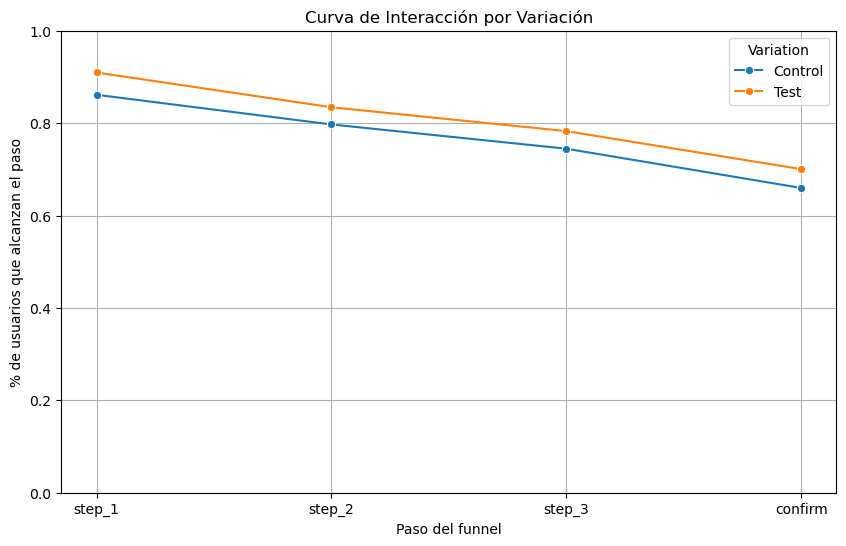

In [255]:
step_counts = df_web_sorted[df_web_sorted['Variation'].isin(['Control', 'Test'])].groupby(['Variation', 'process_step'])['client_id'].nunique().reset_index()
step_order = ['step_1', 'step_2', 'step_3', 'confirm']
step_counts['process_step'] = pd.Categorical(step_counts['process_step'], categories=step_order, ordered=True)
step_counts = step_counts.sort_values('process_step')
totals = step_counts.groupby('Variation')['client_id'].transform('max')
step_counts['percent'] = step_counts['client_id'] / totals

plt.figure(figsize=(10, 6))
sns.lineplot(data=step_counts, x='process_step', y='percent', hue='Variation', marker='o')
plt.title('Curva de Interacción por Variación')
plt.ylabel('% de usuarios que alcanzan el paso')
plt.xlabel('Paso del funnel')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

La forma de la curva sugiere un patrón claro y estable, no ruido aleatorio.

### Evaluación de la duración

#### **¿La duración fue adecuada?**

La duración del experimento (3 meses) fue adecuada para observar resultados concluyentes. La cantidad de usuarios participantes permitió generar curvas de conversión estables y consistentes, y se observaron diferencias claras y sostenidas entre Control y Test en cada paso del funnel. Por lo tanto, el periodo experimental fue suficiente para evaluar la efectividad del rediseño.

## Necesidades adicionales de datos

**¿Qué otros datos podrían ayudar a mejorar o profundizar el análisis?**

1. Feedback cualitativo de los usuarios
Incorporar opiniones, comentarios y sugerencias directas de los usuarios puede aportar información que no se capta solo con datos cuantitativos. Por ejemplo:

- Encuestas de satisfacción tras completar (o abandonar) el proceso.

- Comentarios abiertos donde expliquen qué les gustó o qué dificultades encontraron.

Esto permite identificar puntos de dolor no evidentes en los datos técnicos y priorizar mejoras centradas en la experiencia real del usuario.

2. Datos específicos de fallos y errores técnicos en la web
Tener registros detallados de los errores que ocurren en la plataforma ayuda a entender las barreras técnicas que enfrentan los usuarios. Por ejemplo:

- Contadores automáticos de errores frecuentes (timeouts, caídas de la página, scripts que no cargan).

- Logs de errores con timestamps y contexto (por ejemplo, qué paso del funnel estaba activo cuando ocurrió el fallo).

- Datos de rendimiento web, como tiempo de carga de cada paso, latencia, y tasa de fallos en la conexión.

Esto permite correlacionar directamente errores técnicos con abandonos o repeticiones de pasos, facilitando diagnósticos precisos.

3. Datos sobre el rendimiento y estrategia de la competencia
Analizar cómo se comporta la competencia o el mercado puede aportar contexto estratégico para tu análisis, por ejemplo:


- Información sobre funcionalidades que ofrecen y cómo afectan la experiencia.

- Opiniones y valoraciones de usuarios sobre webs similares para detectar qué les gusta o disgusta.

Esto ayuda a identificar oportunidades para mejorar o diferenciar la plataforma y justificar recomendaciones basadas en estándares o prácticas exitosas.

4. Presupuesto y recursos para la nueva web
Contar con datos claros sobre el presupuesto asignado para el desarrollo, mantenimiento y mejora de la nueva web es fundamental para:

- Definir el alcance de las mejoras técnicas y funcionales posibles.

- Priorizar funcionalidades o correcciones según el costo-beneficio.

Esta información permite ajustar las recomendaciones a la realidad económica del proyecto y evitar propuestas inviables.

